In [19]:
from __future__ import print_function

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as dates
%matplotlib inline
import seaborn as sns

# Ipynb Widgets
from  ipywidgets  import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

# Basic
import numpy as np
import pandas as pd
import datetime
from datetime import datetime as dt
from datetime import timedelta

# Utilities
import warnings
import os 
import math
import sys

# CR2C
import cr2c_labdata as pld
import cr2c_hmidata as hmi
import cr2c_fielddata as fld
import cr2c_validation as val


In [2]:
hmi_path = '/Users/josebolorinos/Google Drive/Codiga Center/HMI Data/Influent Pumps_20180713030602.csv'
hmi_run = hmi.hmi_data_agg('1-24-18','7-12-18', hmi_path = hmi_path)

# Get a clean hmi dataset
pumpDat = hmi_run.prep_data('FT200','WATER')


yes
yes


In [28]:
# Get duration of flow reading registered by meter
pumpDat.loc[:,'flowDuration'] = (pumpDat['Time'] - pumpDat['Time'].shift(-1))/np.timedelta64(1,'m')

# Get a dataset of zero flow events
pumpDat.loc[:,'zeroFlow'] = 0
pumpDat.loc[pumpDat['Value'] < 1,'zeroFlow'] = 1
pumpDat.loc[:,'gradient'] = \
    (pumpDat['Value'].shift(-1) - pumpDat['Value'])/\
    ((pumpDat['Time'].shift(-1) - pumpDat['Time'])/np.timedelta64(1,'m'))

# pumpDattest = pumpDat.loc[
#     (pumpDat.Time >= datetime.datetime(2018,3,11,12,0)) & 
#     (pumpDat.Time <= datetime.datetime(2018,3,11,20,0))
# ]

# plt.figure(figsize=(30, 10), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(pumpDattest['Time'],pumpDattest['gradient'])


pumpDat.loc[:,'hiGradient'] = 0
pumpDat.loc[abs(pumpDat['gradient']) > 30,'hi_gradient'] = 1
pumpDat.loc[:,'fastCycle'] = 0
pumpDat.loc[
    abs(pumpDat['gradient'].shift(-1) - pumpDat['gradient']) > 60,
    'fastCycle'
] = 1

# Get a dataset of zero flow events
pumpDatZero = pumpDat.loc[pumpDat['zeroFlow'] == 1,:]

# Compute time since last zero flow event and merge to original dataset
pumpDatZero.loc[:,'timeOn'] = (pumpDatZero['Time'] - pumpDatZero['Time'].shift(1))/np.timedelta64(1,'m')
pumpDatZero.loc[:,'timeOn'] = pumpDatZero['timeOn']
pumpDatMerged = pumpDat.merge(pumpDatZero, how = 'outer')

# Drop duplicates and sort
pumpDatMerged.drop_duplicates(inplace = True)
pumpDatMerged.sort_values('Time', inplace = True)

# Fill missing "timeOn" values forward
pumpDatMerged.loc[:,'timeOn'] = pumpDatMerged['timeOn'].fillna(method = 'bfill')


/anaconda3/envs/cr2c-monitoring/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/cr2c-monitoring/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [40]:
# Use time since last zero flow event to assign observations to "stable" or 'short'
pumpDatMerged.loc[:,'type'] = 'stable'
pumpDatMerged.loc[pumpDatMerged['timeOn'] < 5,'type'] = 'short'
# Create hour and date variables
pumpDatMerged['Hour'] = pumpDatMerged['Time'].astype('datetime64[h]')
pumpDatMerged.loc[:,'Date'] = pumpDatMerged['Time'].dt.date

# Get hourly and daily flow average under "stable" operating conditions
pumpDatStable = pumpDatMerged.loc[pumpDatMerged['type'] == 'stable',:]
stableFlowHourly = \
    pumpDatStable.groupby(['Hour']).\
    apply(lambda x: np.average(x.Value, weights = x.flowDuration))
stableFlowDaily = \
    pumpDatStable.groupby(['Date']).\
         

# Get number of daily zero flow events
pumpProfilesHourly = pumpDatMerged[['Hour','zeroFlow','fastCycle']].groupby(['Hour']).sum()
pumpProfilesHourly['avStableFlow'] = stableFlowHourly
pumpProfilesHourly.reset_index(inplace = True)
pumpProfilesHourly.loc[:,'Month'] = pumpProfilesHourly['Hour'].dt.month
pumpProfilesHourly.loc[:,'Hour of Day'] = pumpProfilesHourly['Hour'].dt.hour
pumpProfilesHourly.rename(columns = {'Hour':'Time'}, inplace = True)

# Get number hourly zero flow events
pumpProfilesDaily = pumpDatMerged[['Date','zeroFlow','fastCycle']].groupby(['Date']).sum()
pumpProfilesDaily['avStableFlow'] = stableFlowDaily
pumpProfilesDaily.reset_index(inplace = True)
pumpProfilesDaily.rename(columns = {'Date':'Time'}, inplace = True)

# Get daily profile of pump stops
pumpProfilesByHour = pumpProfilesHourly.groupby(['Hour of Day','Month']).mean()
pumpProfilesByHour.reset_index(inplace = True)
pumpProfilesByHour.rename(columns = {'Hour of Day':'Hour'}, inplace = True)


plotdfs = {
    'Hourly': pumpProfilesHourly, 
    'Daily': pumpProfilesDaily
}


In [45]:
def pumpsPlot(tinterval, plotdfs, yaxlimsFlow, yaxlimsStops):
    
    if tinterval == 'Hourly':
        df = plotdfs['Hourly']
    else:
        df = plotdfs['Daily']
      
    sns.set_style('white')
    plt.figure(figsize=(30, 20), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot2grid((14,1),(0,0), rowspan = 4)
    ax1.plot(df['Time'], df['avStableFlow'], 'g-', linewidth = 0.75)
    ax1.set_title(
        'Av. Stable Pump Flow',
        fontweight = 'bold',
        fontsize = 24
    )
    ax1.set_ylabel('Average Flow (gpm)', fontsize = 22)
    ax1.xaxis.set_ticklabels([])
    ylabels1 = ax1.get_yticklabels()
    if yaxlimsFlow:
        ax1.set_ylim([yaxlimsFlow[0],yaxlimsFlow[1]])
    plt.setp(ylabels1, fontsize=20)
    
    ax2 = plt.subplot2grid((14,1),(5,0), rowspan = 4)
    ax2.plot(df['Time'], df['zeroFlow'], 'r-', linewidth = 1)
    ax2.set_title(
        'Zero Flow Events',
        fontweight = 'bold',
        fontsize = 24
    )
    ax2.set_ylabel('Zero Flow Events', fontsize = 22)
    
    ax3 = plt.subplot2grid((14,1),(10,0), rowspan = 4)
    ax3.plot(df['Time'], df['fastCycle'], 'b-', linewidth = 1)
    ax3.set_title(
        'Cycling Events',
        fontweight = 'bold',
        fontsize = 24
    )
    ax3.set_ylabel('Cycling Events', fontsize = 22)
    
    if yaxlimsStops:
        ax2.set_ylim([yaxlimsStops[0],yaxlimsStops[1]])
    xlabels = ax2.get_xticklabels()
    ylabels2 = ax2.get_yticklabels()
    plt.setp(ylabels2, fontsize=20)
    plt.setp(xlabels, rotation=45, fontsize=20)



interact(
    pumpsPlot, 
    tinterval = ['Hourly','Daily'],
    plotdfs = fixed(plotdfs),
    yaxlimsFlow = fixed(None),
    yaxlimsStops = fixed(None)
)


interactive(children=(Dropdown(description='tinterval', options=('Hourly', 'Daily'), value='Hourly'), Output()…

<function __main__.pumpsPlot(tinterval, plotdfs, yaxlimsFlow, yaxlimsStops)>

/anaconda3/envs/cr2c-monitoring/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
/anaconda3/envs/cr2c-monitoring/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead


SelectionSlider(continuous_update=False, description='start', options=(('2017-11-02', Timestamp('2017-11-02 00…

SelectionSlider(continuous_update=False, description='end', index=250, options=(('2017-11-02', Timestamp('2017…

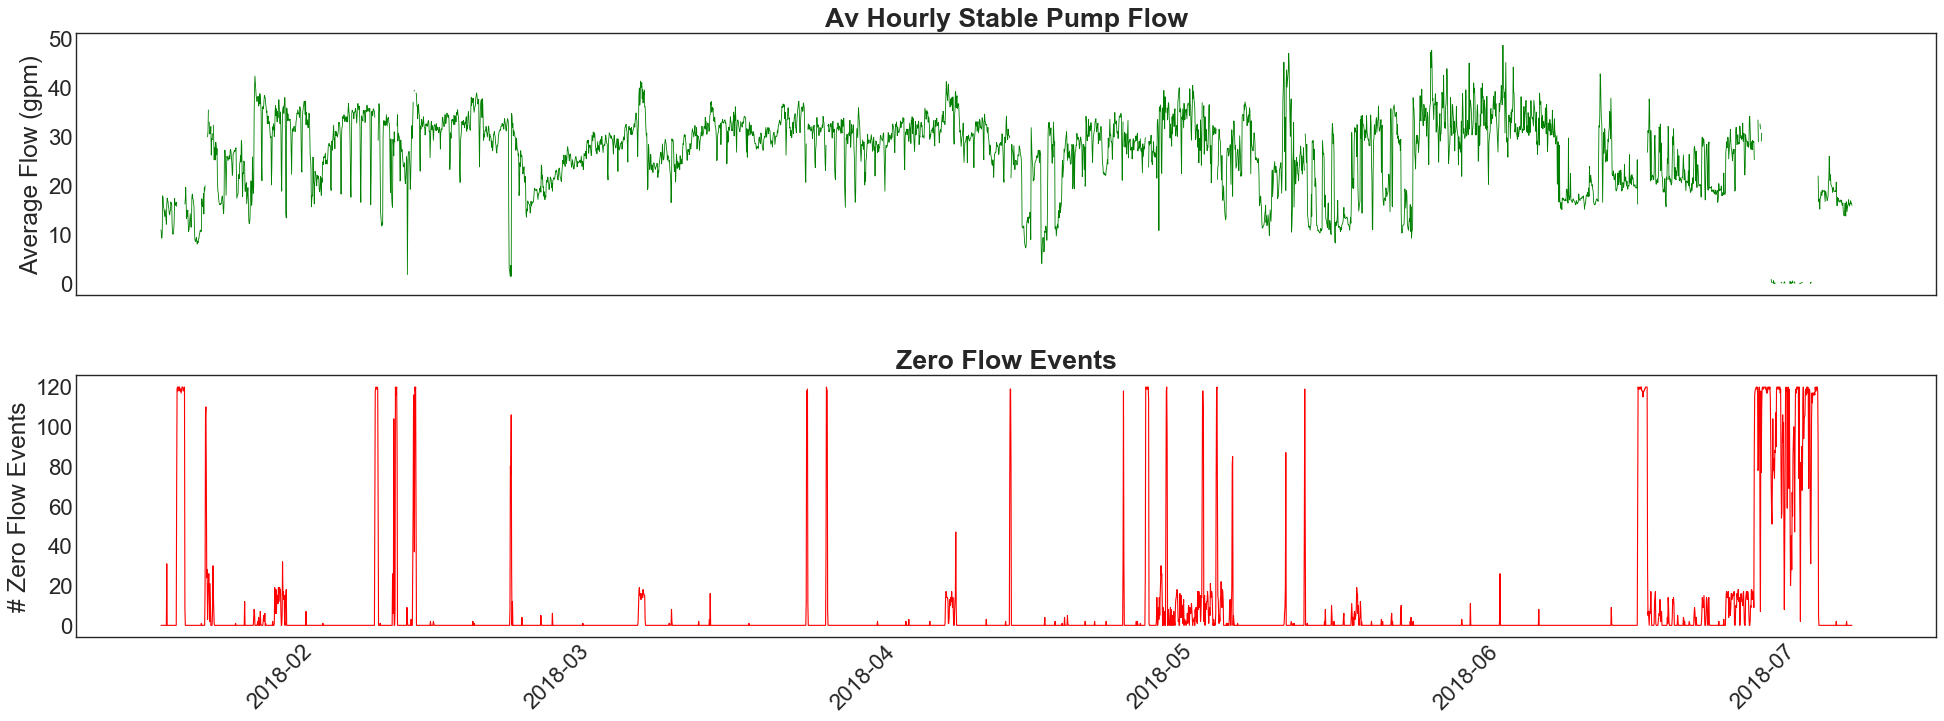

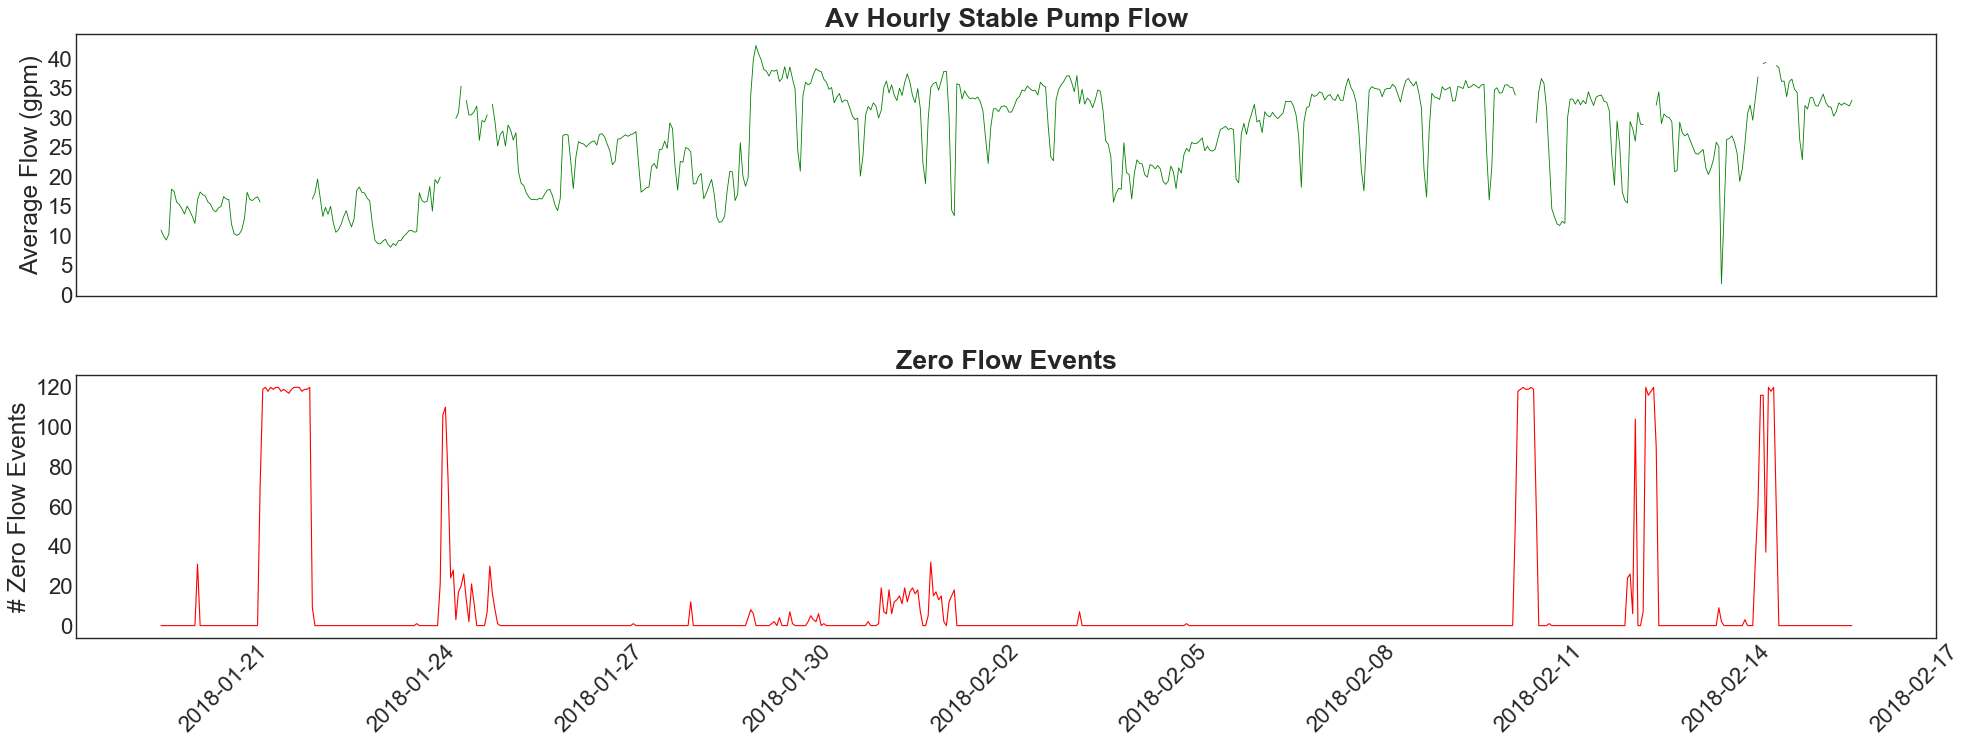

In [67]:
class DateRangePicker(object):
    def __init__(self,start,end,freq='D',fmt='%Y-%m-%d'):
        """
        Parameters
        ----------
        start : string or datetime-like
            Left bound of the period
        end : string or datetime-like
            Left bound of the period
        freq : string or pandas.DateOffset, default='D'
            Frequency strings can have multiples, e.g. '5H' 
        fmt : string, defauly = '%Y-%m-%d'
            Format to use to display the selected period

        """
        self.date_range=pd.date_range(start=start,end=end,freq=freq)
        options = [(item.strftime(fmt),item) for item in self.date_range]
        self.slider_start = widgets.SelectionSlider(
            description='start',
            options=options,
            continuous_update=False
        )
        self.slider_end = widgets.SelectionSlider(
            description='end',
            options=options,
            continuous_update=False,
            value=options[-1][1]
        )

        self.slider_start.on_trait_change(self.slider_start_changed, 'value')
        self.slider_end.on_trait_change(self.slider_end_changed, 'value')

        self.widget = widgets.Box(children=[self.slider_start,self.slider_end])

    def slider_start_changed(self,key,value):
        self.slider_end.value=max(self.slider_start.value,self.slider_end.value)
        self._observe(start=self.slider_start.value,end=self.slider_end.value)

    def slider_end_changed(self,key,value):
        self.slider_start.value=min(self.slider_start.value,self.slider_end.value)
        self._observe(start=self.slider_start.value,end=self.slider_end.value)

    def display(self):
        display(self.slider_start,self.slider_end)

    def _observe(self,**kwargs):
        if hasattr(self,'observe'):
            self.observe(**kwargs)

def pumpsPlot(start, end, plotdfs = plotdfs):
    
    df = plotdfs['Hourly']
    df = df.loc[(df.Time >= start) & (df.Time <= end)]
    
    sns.set_style('white')
    plt.figure(figsize=(30, 10), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot2grid((9,1),(0,0), rowspan = 4)
    ax1.plot(df['Time'], df['avStableFlow'], 'g-', linewidth = 0.75)
    ax1.set_title(
        'Av Hourly Stable Pump Flow',
        fontweight = 'bold',
        fontsize = 24
    )
    ax1.set_ylabel('Average Flow (gpm)', fontsize = 22)
    ax1.xaxis.set_ticklabels([])
    ylabels1 = ax1.get_yticklabels()
    plt.setp(ylabels1, fontsize=20)
    
    ax2 = plt.subplot2grid((9,1),(5,0), rowspan = 4)
    ax2.plot(df['Time'], df['zeroFlow'], 'r-', linewidth = 1)
    ax2.set_title(
        'Zero Flow Events',
        fontweight = 'bold',
        fontsize = 24
    )
    ax2.set_ylabel('# Zero Flow Events', fontsize = 22)
    xlabels = ax2.get_xticklabels()
    ylabels2 = ax2.get_yticklabels()
    plt.setp(ylabels2, fontsize=20)
    plt.setp(xlabels, rotation=45, fontsize=20)



w = DateRangePicker(start = '2017-11-02',end = "2018-07-10",freq='D',fmt='%Y-%m-%d')
w.observe= pumpsPlot
w.display()

In [59]:

def pumpsPlot(plotdfs, Month, yaxlimsFlow, yaxlimsStops):
    
    df = plotdfs.loc[plotdfs.Month == Month]
    
    sns.set_style('white')
    plt.figure(figsize=(30, 10), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = plt.subplot2grid((9,1),(0,0), rowspan = 4)
    ax1.plot(df['Hour'], df['avStableFlow'], 'g-', linewidth = 0.75)
    ax1.set_title(
        'Av. Stable Pump Flow',
        fontweight = 'bold',
        fontsize = 24
    )
    ax1.set_ylabel('Average Flow (gpm)', fontsize = 22)
    ax1.xaxis.set_ticklabels([])
    ylabels1 = ax1.get_yticklabels()
    if yaxlimsFlow:
        ax1.set_ylim([yaxlimsFlow[0],yaxlimsFlow[1]])
    plt.setp(ylabels1, fontsize=20)
    
    ax2 = plt.subplot2grid((9,1),(5,0), rowspan = 4)
    ax2.plot(df['Hour'], df['zeroFlow'], 'r-', linewidth = 1)
    ax2.set_title(
        'Zero Flow Events',
        fontweight = 'bold',
        fontsize = 24
    )
    ax2.set_ylabel('# Zero Flow Events', fontsize = 22)
    if yaxlimsStops:
        ax2.set_ylim([yaxlimsStops[0],yaxlimsStops[1]])
    xlabels = ax2.get_xticklabels()
    ylabels2 = ax2.get_yticklabels()
    plt.setp(ylabels2, fontsize=20)
    plt.setp(xlabels, rotation=45, fontsize=20)

interact(
    pumpsPlot, 
    plotdfs = fixed(pumpProfilesByHour),
    Month = list(range(13))[1:],
    yaxlimsFlow = fixed(None),
    yaxlimsStops = fixed(None)
)

interactive(children=(Dropdown(description='Month', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1),…

<function __main__.pumpsPlot(plotdfs, Month, yaxlimsFlow, yaxlimsStops)>